<a href="https://colab.research.google.com/github/alartuka/Arven/blob/main/arven_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Img](https://app.theheadstarter.com/static/hs-logo-opengraph.png)

# Headstarter RAG Workshop

**Skills: HuggingFace, LangChain, Pinecone**

**Other Resources:**
- [Get your Groq API Key](https://console.groq.com/keys)
- [Get your Pinecone API Key](https://www.pinecone.io/)


### What is RAG anyway?


![withoutRAG](https://github.com/user-attachments/assets/649d6101-b63a-4750-997a-b6abc25e5609)

![withRAG](https://github.com/user-attachments/assets/e6dd9c46-0bf9-4c31-bd72-a27939ef82b8)

Retrieval-Augmented Generation (RAG) is a technique primarily used in GenAI applications to improve the quality and accuracy of generated text by LLMs by combining two key processes: retrieval and generation.

### Breaking It Down:
#### Retrieval:

- Before generating a response, the system first looks up relevant information from a large database or knowledge base. This is like searching through a library or the internet to find the most useful facts, articles, or data related to the question or topic.

#### Generation:

- Once the relevant information is retrieved, the system then uses it to help generate a response. This is where the model, like GPT, creates new text (answers, explanations, etc.) based on the retrieved information.

# Install libraries

In [1]:
! pip install langchain langchain-community openai groq tiktoken pinecone-client langchain_pinecone unstructured pdfminer==20191125 pdfminer.six==20221105 pillow_heif unstructured_inference sentence-transformers exa-py

In [2]:
from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader, WebBaseLoader, YoutubeLoader, DirectoryLoader, TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics.pairwise import cosine_similarity
from langchain_pinecone import PineconeVectorStore
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from google.colab import userdata
from langchain.schema import Document
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone
from openai import OpenAI
import numpy as np
import tiktoken
import os
from groq import Groq
from exa_py import Exa
import hashlib
import json
from datetime import datetime
import time



pinecone_api_key = userdata.get("PINECONE_API_KEY")
os.environ['PINECONE_API_KEY'] = pinecone_api_key

openai_api_key = userdata.get("OPENAI_API_KEY")
os.environ['OPENAI_API_KEY'] = openai_api_key
openai_client = OpenAI()

groq_api_key = userdata.get("GROQ_API_KEY")
os.environ['GROQ_API_KEY'] = groq_api_key

exa_api_key = userdata.get("EXA_API_KEY")
os.environ['EXA_API_KEY'] = exa_api_key


# Initialize the HuggingFace Embeddings client

In [3]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/tmp/ipython-input-3-3409896792.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models o

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Example

In [ ]:
# text = "Hello my name is Faizan"

# query_result = embeddings.embed_query(text)

In [ ]:
# query_result

In [ ]:
# len(query_result)

# Initialize the Groq client

In [4]:
# Free Llama 3.1 API via Groq

groq_client = Groq(api_key=os.getenv('GROQ_API_KEY'))

# initialize openAI client
openai_client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

# Calculating sentence similarity with embeddings

In [5]:
def get_huggingface_embeddings(text, model_name="sentence-transformers/all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    return model.encode(text)


def cosine_similarity_between_sentences(sentence1, sentence2):
    # Get embeddings for both sentences
    embedding1 = np.array(get_huggingface_embeddings(sentence1))
    embedding2 = np.array(get_huggingface_embeddings(sentence2))

    # Reshape embeddings for cosine_similarity function
    embedding1 = embedding1.reshape(1, -1)
    embedding2 = embedding2.reshape(1, -1)

    print("Embedding for Sentence 1:", embedding1)
    print("\nEmbedding for Sentence 2:", embedding2)

    # Calculate cosine similarity
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]


# Example usage
sentence1 = "I like running to the park"
sentence2 = "I like running to the office"


similarity = cosine_similarity_between_sentences(sentence1, sentence2)
print(f"\n\nCosine similarity between '{sentence1}' and '{sentence2}': {similarity:.4f}")

Embedding for Sentence 1: [[ 1.23337246e-02 -5.13279764e-03  3.57208848e-02  3.30768302e-02
   7.82396719e-02 -4.72629350e-03  6.77640066e-02 -1.38818845e-02
   5.46722263e-02  3.72701623e-02 -6.69813827e-02 -1.25908284e-02
  -3.56482230e-02  1.04401549e-02  7.53818303e-02  2.34690451e-04
   5.66774085e-02  5.25491722e-02 -3.24604735e-02  5.10555133e-02
  -7.36738369e-02  2.87814029e-02  4.96469587e-02  1.52121764e-02
  -1.48359686e-01  9.21717212e-02 -3.28955650e-02 -1.19502367e-02
  -1.94677711e-02 -1.07078562e-02 -7.19258264e-02 -2.60948092e-02
   3.90276383e-03  2.24410407e-02 -2.83260699e-02  3.94298211e-02
   3.03058382e-02 -6.47537112e-02 -2.83420784e-03  6.29675165e-02
   5.27709723e-03 -2.52472498e-02  6.72674701e-02 -6.20138133e-04
  -2.60539651e-02 -1.77838989e-02 -1.57480724e-02 -1.01696076e-02
   1.10002562e-01 -2.35369720e-04  1.14311509e-01 -1.48504437e-03
   1.67892501e-02 -2.43191961e-02  3.09247011e-03  3.71284708e-02
  -8.57886225e-02  4.56232540e-02  3.15336883e-02 

# Load in the Data

Learn more about the dataset [here](https://www.kaggle.com/datasets/ayoubcherguelaine/company-documents-dataset)

In [ ]:
# ! kaggle datasets download -d ayoubcherguelaine/company-documents-dataset
# ! unzip company-documents-dataset.zip

In [ ]:
# def process_directory(directory_path):
#     data = []
#     for root, _, files in os.walk(directory_path):
#         for file in files:

#             file_path = os.path.join(root, file)
#             print(f"Processing file: {file_path}")
#             loader = PyPDFLoader(file_path)
#             data.append({"File": file_path, "Data": loader.load()})

#     return data

# directory_path = "/content/CompanyDocuments"
# documents = process_directory(directory_path)


In [ ]:
# documents

# Initialize Exa

In [6]:
exa = Exa(api_key = os.getenv('EXA_API_KEY'))

Search and scrape Information/content about Aven from the web including the company's site

Total results collected: 90
[Result(url='https://www.aven.com/about/', id='https://www.aven.com/about/', title='About | Aven Card', score=0.3274889886379242, published_date='2024-01-01T00:00:00.000Z', author='', image=None, favicon='https://www.aven.com/favicon.ico', subpages=None, extras=None, text='[iframe](https://td.doubleclick.net/td/rul/694650136?random=1718502603495&cv=11&fst=1718502603495&fmt=3&bg=ffffff&guid=ON&async=1&gtm=45be46c0v876805295z8898398875za201zb898398875&gcd=13l3l3l3l1&dma=0&tag_exp=0&u_w=800&u_h=600&url=http%3A%2F%2F127.0.0.1%3A8000%2Fabout&label=S-0rCOXfrNIDEJiKnssC&hn=www.googleadservices.com&frm=0&tiba=About%20%7C%20Aven%20Card&value=0&bttype=purchase&npa=0&auid=1589046342.1718502599&uaa=x86&uab=64&uafvl=Chromium%3B125.0.6422.0%7CNot.A%252FBrand%3B24.0.0.0&uamb=0&uam=&uap=Linux&uapv=6.5.0&uaw=0&fledge=1&capi=1&ct_cookie_present=0)[iframe](about:blank)[iframe](https://td.doubleclick.net/td/rul/694650136?random=1718502605484&cv=11&fst=1718502605484&fmt=3&bg=fff
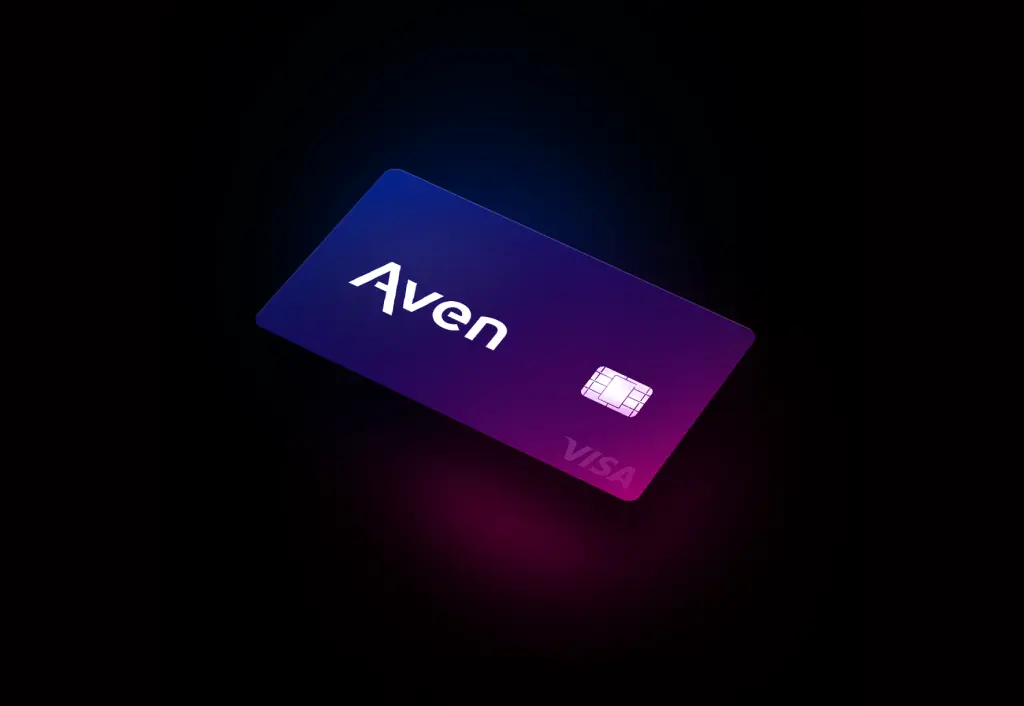
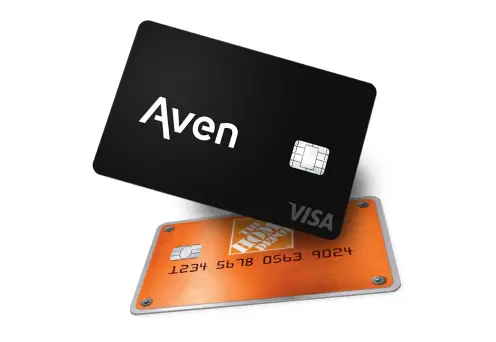
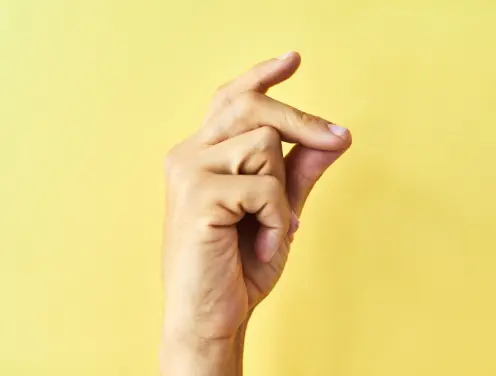
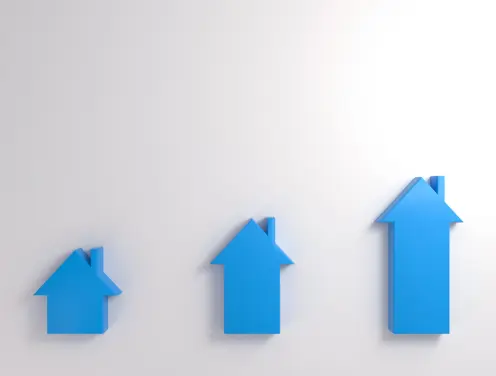
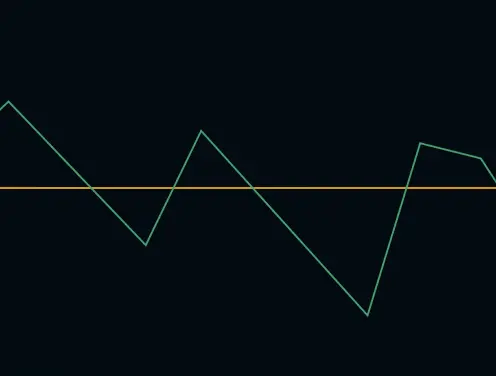
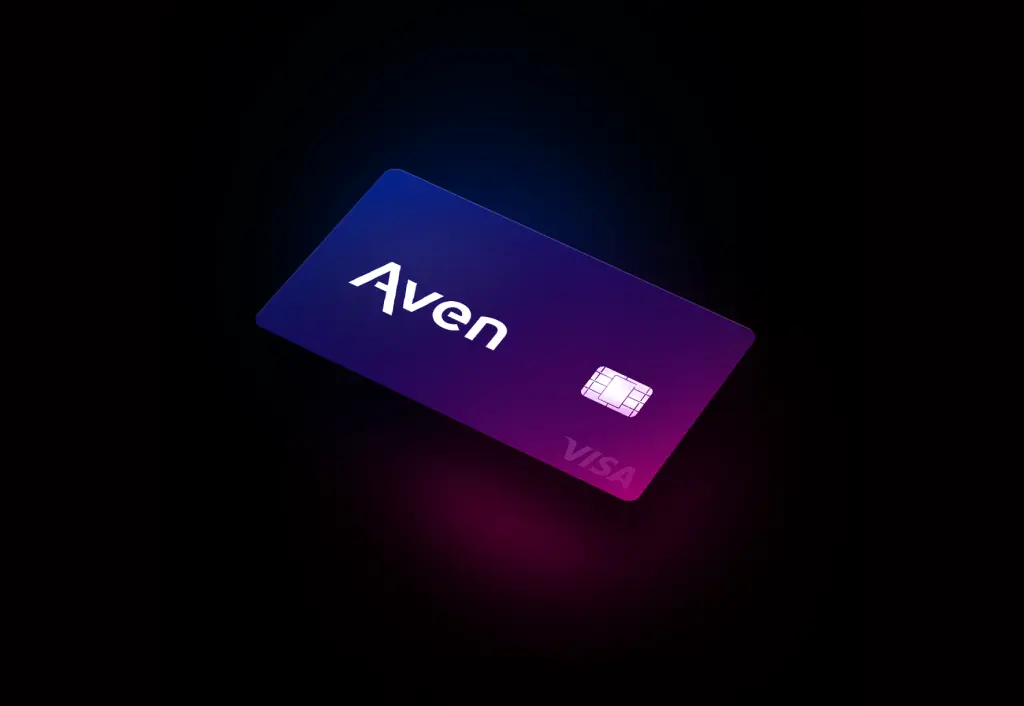
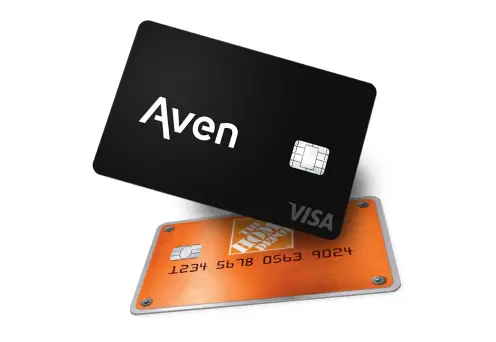
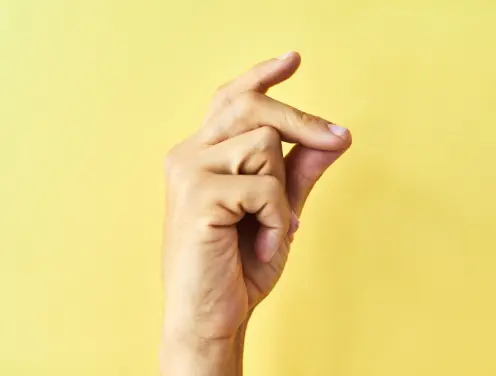
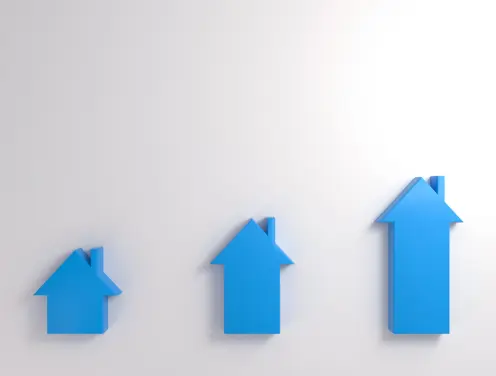
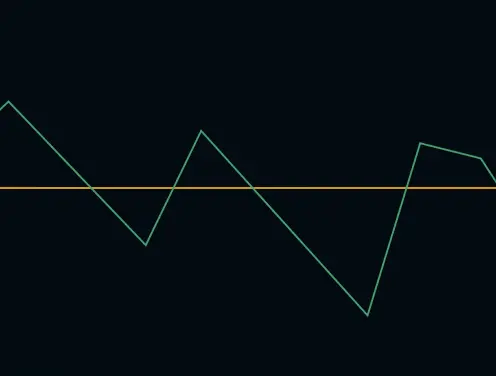
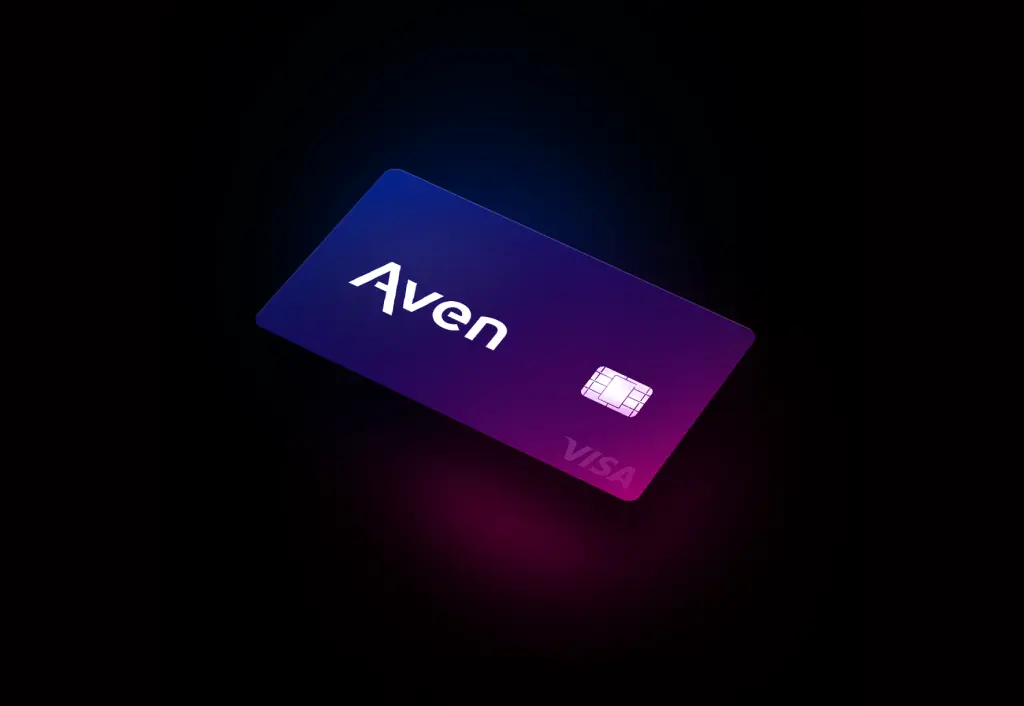
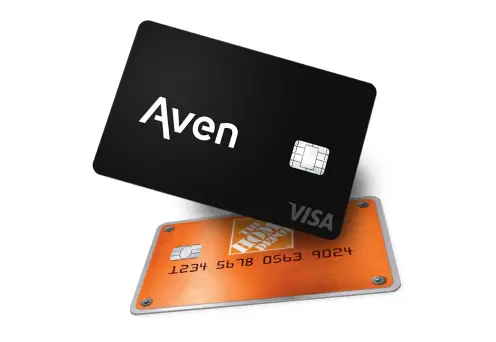
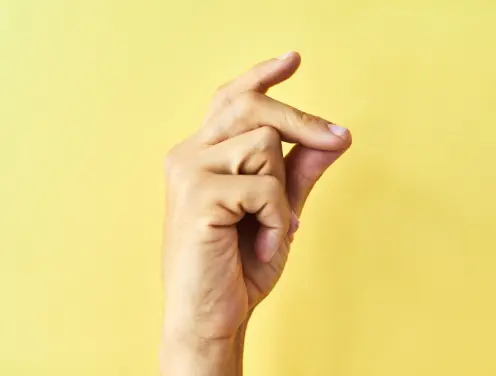
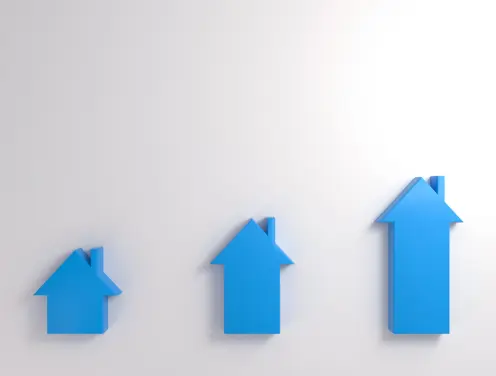
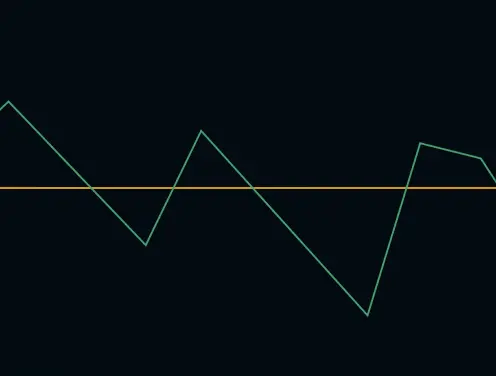
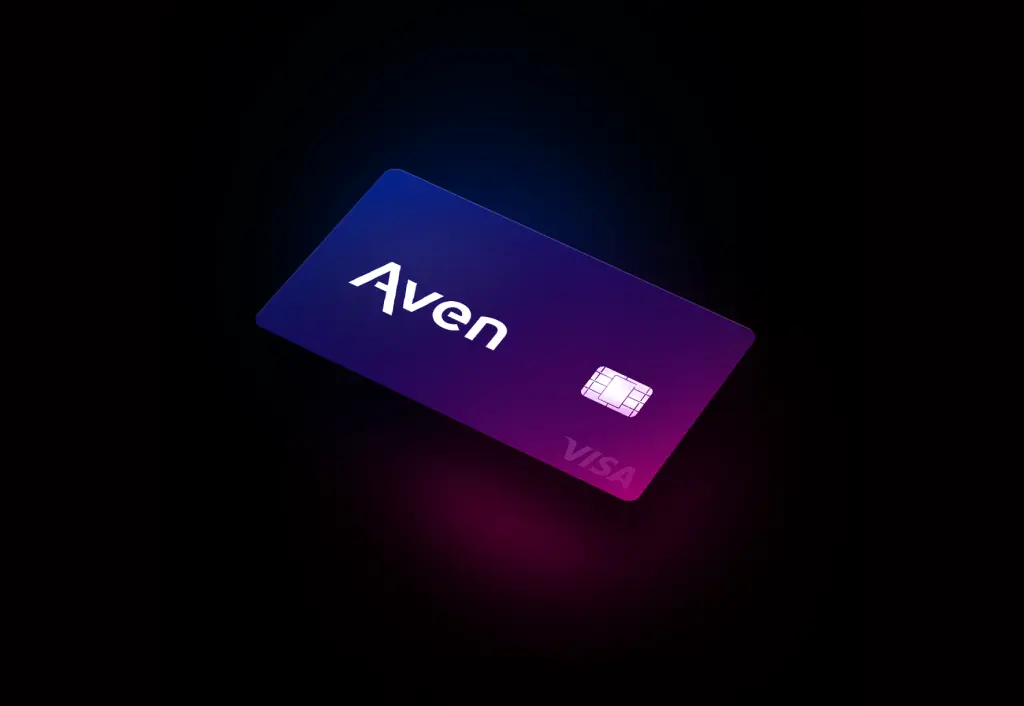
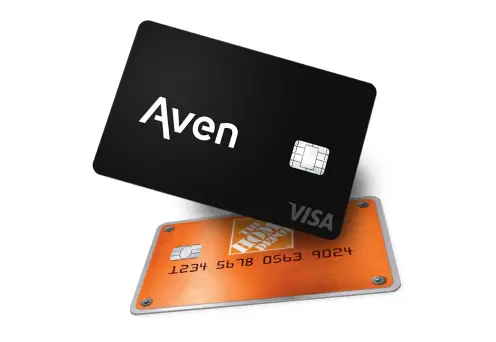
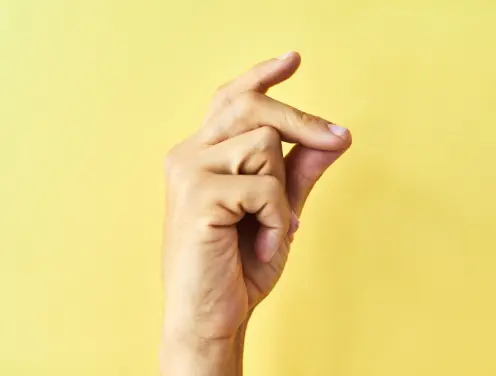
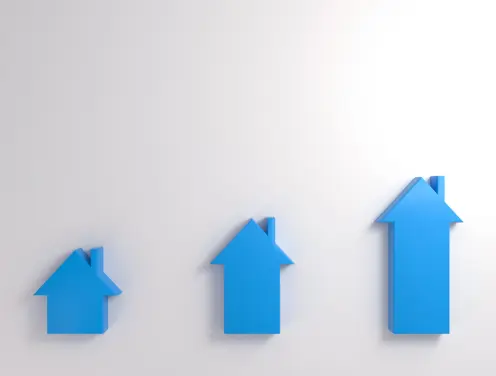
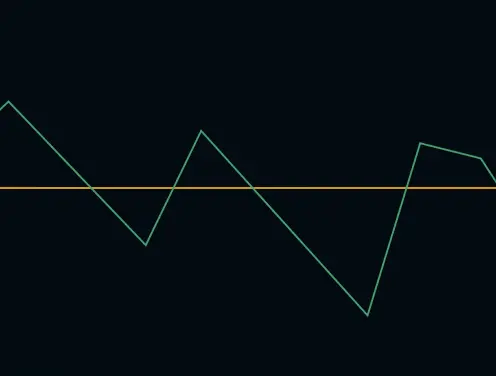
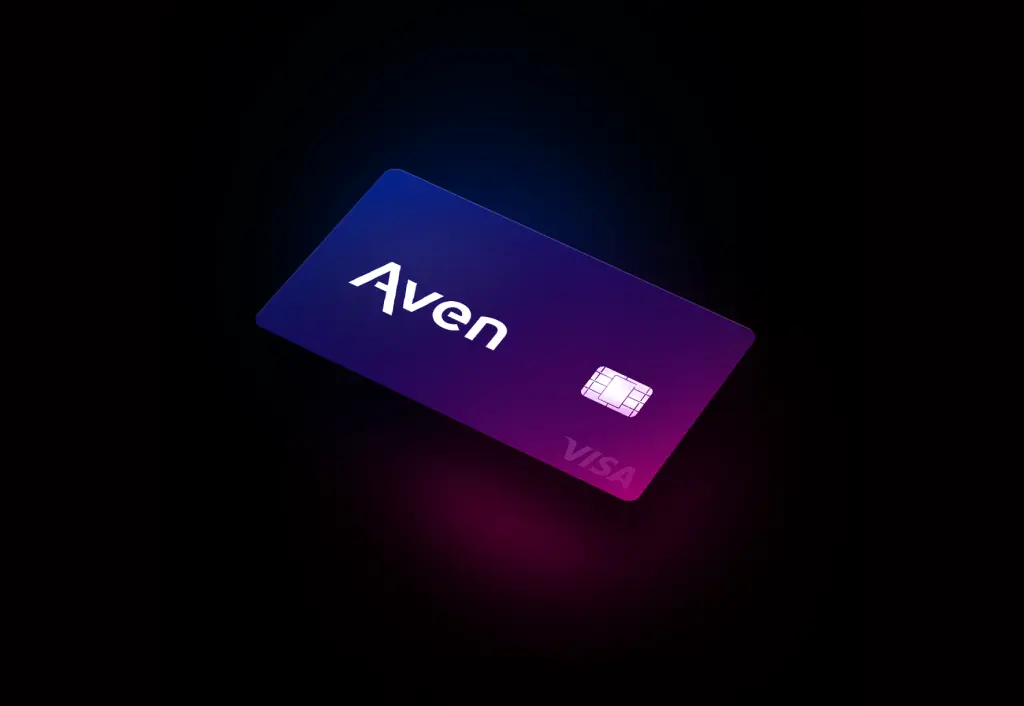
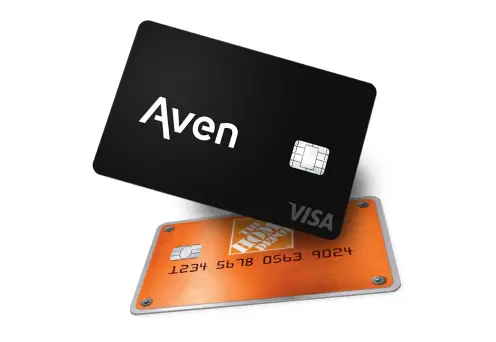
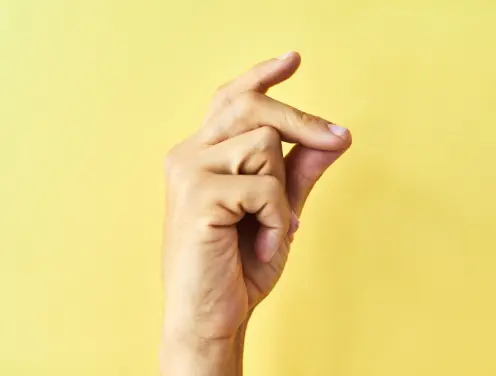
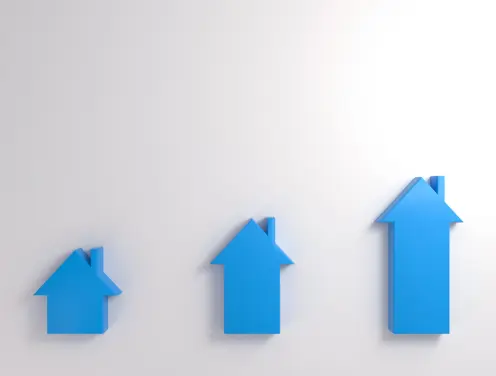
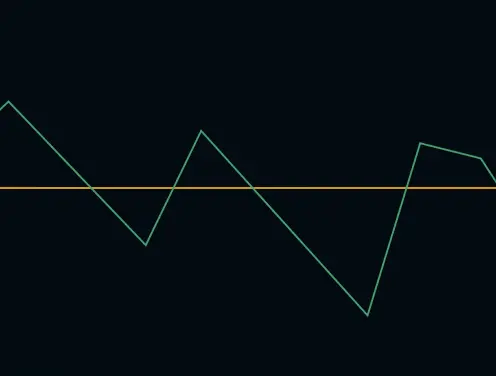
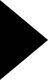
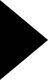

In [7]:
company_name = "Aven"
num_results = 100
all_results = []

# Search queries for different types of content
search_queries = [
    f'site:aven.com aven card',
    f'site:aven.com "aven card" support articles',
    f'site:aven.com "aven card" education how it works',
    f'site:aven.com "aven card" reviews and testimonials',
    f'site:aven.com "aven card" about us'
    # f'news articles blogs about "{company_name}" Card the financial services fintech company',
    # f"{company_name} financial services fintech",
    # f"{company_name} company profile information about",
    # f"{company_name} products services offerings"
]

for query in search_queries:
    try:
        results = exa.search_and_contents(
            query=query,
            type="neural",
            num_results=num_results // len(search_queries),
            text=True,
            highlights=True,
            use_autoprompt=True,
            start_published_date="2023-01-01"
        )
        all_results.extend(results.results)
    except Exception as e:
        print(f"Error searching for query '{query}': {e}")
        continue

print(f"Total results collected: {len(all_results)}")
print(all_results)

# Initialize Pinecone

In [8]:
# Make sure to create a Pinecone index with 384 dimensions
# You don't need to create a namespace through Pinecone, we will just define the name of the namespace here and use it later

index_name = "arven"

namespace = "company-documents"

vectorstore = PineconeVectorStore(index_name=index_name, embedding=embeddings)

# Insert data into Pinecone

In [9]:
# Adapted document processing for Exa results
# Complete fix with chunking and minimal metadata

from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import hashlib

# Initialize text splitter for chunking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      # Smaller chunks
    chunk_overlap=200,    # Some overlap between chunks
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]
)

document_data = []

print(f"Processing {len(all_results)} Exa results with chunking...")

for i, exa_result in enumerate(all_results):
    try:
        # Extract data from Exa result
        document_content = getattr(exa_result, 'text', '') or getattr(exa_result, 'content', '')
        document_source = getattr(exa_result, 'url', 'unknown')
        title = getattr(exa_result, 'title', 'Unknown Title')
        published_date = getattr(exa_result, 'published_date', '')

        # Skip if no content
        if not document_content or len(document_content.strip()) < 100:
            continue

        # Create unique content hash
        content_hash = hashlib.md5(document_content.encode()).hexdigest()[:8]

        # Split content into chunks
        chunks = text_splitter.split_text(document_content)

        # Process each chunk
        for chunk_idx, chunk in enumerate(chunks):
            if len(chunk.strip()) < 50:  # Skip very small chunks
                continue

            # Create MINIMAL metadata (this is the key!)
            minimal_metadata = {
                "source": document_source[:200],  # Truncate URL if very long
                "title": title[:100],             # Truncate title
                "chunk": chunk_idx,               # Chunk index
                "doc_id": f"{content_hash}_{chunk_idx}",  # Unique ID
                "company": company_name,
                "date": str(published_date)[:10] if published_date else "",  # Just date part
            }

            # Create simple page content (NO extra formatting that adds size)
            page_content = chunk  # Just the chunk content, no extra wrapper

            doc = Document(
                page_content=page_content,
                metadata=minimal_metadata
            )

            document_data.append(doc)

        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(all_results)} results...")

    except Exception as e:
        print(f"Error processing result {i}: {e}")
        continue

print(f"Created {len(document_data)} document chunks")

# Test metadata size on a few samples
import json

def get_metadata_size(doc):
    return len(json.dumps(doc.metadata).encode('utf-8'))

print("\n🔍 Checking metadata sizes:")
for i in range(min(5, len(document_data))):
    size = get_metadata_size(document_data[i])
    content_size = len(document_data[i].page_content)
    print(f"Doc {i+1}: metadata={size}B, content={content_size}B")

    if size > 40000:
        print(f"❌ STILL TOO LARGE: {size} bytes")
    else:
        print(f"✅ OK: {size} bytes")

# If you're STILL getting errors, try this ultra-minimal version:
def create_ultra_minimal_docs(all_results):
    """Ultra minimal approach - absolutely bare minimum metadata"""
    ultra_minimal_docs = []

    for i, exa_result in enumerate(all_results):
        try:
            content = getattr(exa_result, 'text', '') or getattr(exa_result, 'content', '')
            if not content or len(content.strip()) < 100:
                continue

            # Split into chunks
            chunks = text_splitter.split_text(content)

            for chunk_idx, chunk in enumerate(chunks):
                if len(chunk.strip()) < 50:
                    continue

                # ABSOLUTE MINIMUM metadata
                doc = Document(
                    page_content=chunk,
                    metadata={
                        "id": f"doc_{i}_{chunk_idx}",
                        "company": company_name
                    }
                )

                ultra_minimal_docs.append(doc)

        except Exception as e:
            continue

    return ultra_minimal_docs

# Uncomment this if you're still getting metadata errors:
# print("Using ultra-minimal metadata approach...")
# document_data = create_ultra_minimal_docs(all_results)
# print(f"Created {len(document_data)} ultra-minimal documents")

print(f"\n✅ Ready to upload {len(document_data)} documents to Pinecone")
print("Now try running the PineconeVectorStore.from_documents() again")

Processing 90 Exa results with chunking...
Processed 10/90 results...
Processed 20/90 results...
Processed 30/90 results...
Processed 40/90 results...
Processed 50/90 results...
Processed 60/90 results...
Processed 70/90 results...
Processed 80/90 results...
Processed 90/90 results...
Created 1751 document chunks

🔍 Checking metadata sizes:
Doc 1: metadata=148B, content=1000B
✅ OK: 148 bytes
Doc 2: metadata=148B, content=815B
✅ OK: 148 bytes
Doc 3: metadata=178B, content=909B
✅ OK: 178 bytes
Doc 4: metadata=178B, content=981B
✅ OK: 178 bytes
Doc 5: metadata=178B, content=905B
✅ OK: 178 bytes

✅ Ready to upload 1751 documents to Pinecone
Now try running the PineconeVectorStore.from_documents() again




---



In [ ]:
# for document in documents:
#     print(document['File'], document['Data'])

In [ ]:
# Prepare the text for embedding
# document_data = []
# for document in documents:

#     document_source = document['Data'][0].metadata['source']
#     document_content = document['Data'][0].page_content

#     file_name = document_source.split("/")[-1]
#     folder_names = document_source.split("/")[2:-1]

#     doc = Document(
#         page_content = f"<Source>\n{document_source}\n</Source>\n\n<Content>\n{document_content}\n</Content>",
#         metadata = {
#             "file_name": file_name,
#             "parent_folder": folder_names[-1],
#             "folder_names": folder_names
#         }
#     )
#     document_data.append(doc)



---



In [10]:
document_data

[Document(metadata={'source': 'https://www.aven.com/about/', 'title': 'About | Aven Card', 'chunk': 0, 'doc_id': '15f28ce5_0', 'company': 'Aven', 'date': '2024-01-01'}, page_content='[iframe](https://td.doubleclick.net/td/rul/694650136?random=1718502603495&cv=11&fst=1718502603495&fmt=3&bg=ffffff&guid=ON&async=1&gtm=45be46c0v876805295z8898398875za201zb898398875&gcd=13l3l3l3l1&dma=0&tag_exp=0&u_w=800&u_h=600&url=http%3A%2F%2F127.0.0.1%3A8000%2Fabout&label=S-0rCOXfrNIDEJiKnssC&hn=www.googleadservices.com&frm=0&tiba=About%20%7C%20Aven%20Card&value=0&bttype=purchase&npa=0&auid=1589046342.1718502599&uaa=x86&uab=64&uafvl=Chromium%3B125.0.6422.0%7CNot.A%252FBrand%3B24.0.0.0&uamb=0&uam=&uap=Linux&uapv=6.5.0&uaw=0&fledge=1&capi=1&ct_cookie_present=0)[iframe](about:blank)[iframe](https://td.doubleclick.net/td/rul/694650136?random=1718502605484&cv=11&fst=1718502605484&fmt=3&bg=ffffff&guid=ON&async=1&gtm=45be46c0v876805295za200zb874854766&gcd=13l3l3l3l1&dma=0&tag_exp=0&u_w=800&u_h=600&url=http%3A%2

In [11]:
# Insert documents into Pinecone
vectorstore_from_documents = PineconeVectorStore.from_documents(
    document_data,
    embeddings,
    index_name=index_name,
    namespace=namespace
)

# Perform RAG

In [12]:
# Initialize Pinecone
pc = Pinecone(api_key=userdata.get("PINECONE_API_KEY"),)

# Connect to your Pinecone index
pinecone_index = pc.Index(index_name)

In [13]:
sample_queries = [
    # Product/Service Questions
    "What does Aven do?",
    "What services does Aven offer?",
    "How does Aven's credit card work?",
    "What are the benefits of using Aven?",
    "What makes Aven different from other fintech companies?",

    # Eligibility/Requirements
    "What credit score do I need for Aven?",
    "Who is eligible for Aven's services?",
    "How do I apply for an Aven card?",
    "What documents do I need to apply?",
    "Can I get approved with bad credit?",

    # Fees/Pricing
    "What are Aven's fees?",
    "Does Aven charge annual fees?",
    "What are the interest rates?",
    "Are there any hidden costs?",
    "How much does it cost to use Aven?",

    # Security/Trust
    "Is Aven FDIC insured?",
    "How secure is Aven?",
    "Is my money safe with Aven?",
    "What security measures does Aven have?",
    "Is Aven regulated?",

    # Comparison/Competition
    "Who are Aven's competitors?",
    "How does Aven compare to traditional banks?",
    "Is Aven better than Chime?",
    "What's the difference between Aven and other fintech companies?",
    "Why should I choose Aven over other options?",

    # Features/Functionality
    "What features does Aven offer?",
    "Can I use Aven internationally?",
    "Does Aven have a mobile app?",
    "What payment methods does Aven accept?",
    "Can I set up direct deposit with Aven?",

    # Business/Company Info
    "When was Aven founded?",
    "Who founded Aven?",
    "Where is Aven headquartered?",
    "How much funding has Aven raised?",
    "What's Aven's business model?",

    # Customer Support
    "How do I contact Aven customer support?",
    "What are Aven's support hours?",
    "How do I report a problem with my Aven account?",
    "Does Aven have phone support?",
    "How long does Aven take to respond to support requests?",

    # Account Management
    "How do I close my Aven account?",
    "Can I change my Aven account settings?",
    "How do I update my information with Aven?",
    "What happens if I miss a payment?",
    "How do I increase my credit limit?",

    # Recent/News
    "What's new with Aven?",
    "Has Aven launched any new products recently?",
    "What are people saying about Aven?",
    "Any recent news about Aven?",
    "What's Aven's latest update?"
]

In [ ]:
# query = "What are some items that Pirkko Koskitalo is likely to buy next? What incentives can I put in place to ensure he orders more?"

In [14]:
import random

query = random.choice(sample_queries)

print(query)

Where is Aven headquartered?


In [15]:
raw_query_embedding = get_huggingface_embeddings(query)

In [16]:
raw_query_embedding

array([-5.06206695e-03, -3.11962944e-02, -4.44005467e-02,  4.95409817e-02,
       -2.87756007e-02, -2.22574882e-02, -3.85485515e-02, -2.93587893e-02,
        2.91496217e-02, -2.90036071e-02,  6.69799671e-02,  4.91493791e-02,
       -8.52152258e-02, -3.87721099e-02, -9.97164100e-02, -1.31490733e-02,
        3.44964266e-02, -2.18881276e-02,  6.33662120e-02, -5.42471148e-02,
       -5.18546328e-02, -8.53482634e-03,  5.67046702e-02, -4.99269553e-02,
        4.99543324e-02, -2.27395706e-02,  3.12197674e-03,  7.06516430e-02,
        2.73496062e-02, -6.44227117e-02,  9.41250473e-02, -4.41458225e-02,
        6.31312951e-02,  8.15423392e-03, -5.25965588e-03,  2.83019636e-02,
        4.81009111e-02, -2.67516021e-02,  4.00099382e-02, -1.06763290e-02,
        5.95627166e-02,  2.04296522e-02,  2.81704552e-02, -5.37961163e-02,
        3.14239226e-02, -4.79309596e-02,  1.80439390e-02,  3.33047360e-02,
        9.76373069e-03,  3.11915041e-03,  7.10239336e-02, -5.58569469e-02,
        2.17298628e-03, -

In [17]:
top_matches = pinecone_index.query(vector=raw_query_embedding.tolist(), top_k=3, include_metadata=True, namespace=namespace)
# top_k=5

In [18]:
top_matches

{'matches': [{'id': 'e906776b-8411-4670-9a98-5992251ac19c',
              'metadata': {'chunk': 3.0,
                           'company': 'Aven',
                           'date': '2024-07-18',
                           'doc_id': '9fa674b9_3',
                           'source': 'https://financialregnews.com/aven-gets-funding-for-credit-card-backed-by-home-equity/',
                           'text': 'Aven is currently available in Alabama, '
                                   'Alaska, Arkansas, Arizona, California, '
                                   'Colorado, Florida, Iowa, Illinois, Kansas, '
                                   'Kentucky, Louisiana, Maine, Michigan, '
                                   'Minnesota, Mississippi, North Carolina, '
                                   'North Dakota, Nebraska, New Hampshire, New '
                                   'Jersey, New Mexico, Ohio, Oklahoma, '
                                   'Oregon, Pennsylvania, South Dakota, '
        

In [19]:
contexts = [item['metadata']['text'] for item in top_matches['matches']]

In [20]:
contexts

['Aven is currently available in Alabama, Alaska, Arkansas, Arizona, California, Colorado, Florida, Iowa, Illinois, Kansas, Kentucky, Louisiana, Maine, Michigan, Minnesota, Mississippi, North Carolina, North Dakota, Nebraska, New Hampshire, New Jersey, New Mexico, Ohio, Oklahoma, Oregon, Pennsylvania, South Dakota, Tennessee, Utah, Virginia, Wisconsin, and Wyoming. Its goal is to reach all 50 states by 2025.',
 'Aven is currently available in Alabama, Alaska, Arkansas, Arizona, California, Colorado, Florida, Iowa, Illinois, Kansas, Kentucky, Louisiana, Maine, Michigan, Minnesota, Mississippi, North Carolina, North Dakota, Nebraska, New Hampshire, New Jersey, New Mexico, Ohio, Oklahoma, Oregon, Pennsylvania, South Dakota, Tennessee, Utah, Virginia, Wisconsin, and Wyoming. Its goal is to reach all 50 states by 2025.',
 'Aven is currently available in Alabama, Alaska, Arkansas, Arizona, California, Colorado, Florida, Iowa, Illinois, Kansas, Kentucky, Louisiana, Maine, Michigan, Minnesota,

In [21]:
augmented_query = "<CONTEXT>\n" + "\n\n-------\n\n".join(contexts[ : 10]) + "\n-------\n</CONTEXT>\n\n\n\nMY QUESTION:\n" + query

In [22]:
print(augmented_query)

<CONTEXT>
Aven is currently available in Alabama, Alaska, Arkansas, Arizona, California, Colorado, Florida, Iowa, Illinois, Kansas, Kentucky, Louisiana, Maine, Michigan, Minnesota, Mississippi, North Carolina, North Dakota, Nebraska, New Hampshire, New Jersey, New Mexico, Ohio, Oklahoma, Oregon, Pennsylvania, South Dakota, Tennessee, Utah, Virginia, Wisconsin, and Wyoming. Its goal is to reach all 50 states by 2025.

-------

Aven is currently available in Alabama, Alaska, Arkansas, Arizona, California, Colorado, Florida, Iowa, Illinois, Kansas, Kentucky, Louisiana, Maine, Michigan, Minnesota, Mississippi, North Carolina, North Dakota, Nebraska, New Hampshire, New Jersey, New Mexico, Ohio, Oklahoma, Oregon, Pennsylvania, South Dakota, Tennessee, Utah, Virginia, Wisconsin, and Wyoming. Its goal is to reach all 50 states by 2025.

-------

Aven is currently available in Alabama, Alaska, Arkansas, Arizona, California, Colorado, Florida, Iowa, Illinois, Kansas, Kentucky, Louisiana, Maine, 



---



In [23]:
system_prompt = f"""
Your name is Arven.

You are the official AI assistant for Aven, a financial services and fintech company. Your role is to provide helpful, accurate, and trustworthy information about Aven's products, services, and company to customers and prospective customers.

Core Guidelines:

1. Answer Based on Provided Data
- ONLY answer questions using information from the context data provided to you
- If the provided context doesn't contain sufficient information to answer a question, clearly state: "I don't have enough information in my current knowledge base to answer that question accurately. For the most up-to-date information, please contact Aven customer support or visit our website."
- Never make up or infer information that isn't explicitly stated in the provided context

2. Tone and Voice
- Professional yet approachable: Sound knowledgeable but not overly technical
- Helpful and customer-focused: Prioritize solving the user's problem or answering their question
- Trustworthy: Be transparent about limitations and always provide accurate information
- Concise but complete: Give thorough answers without being unnecessarily verbose

3. Response Structure
For each response:
1. Start with a clear, direct answer to the user's question
2. Provide relevant context and details from the provided data
3. Suggest relevant actions the user can take (when appropriate)

4. Specific Topics to Handle

Products & Services:
- Explain Aven's financial products and services clearly
- Highlight key features and benefits
- Compare different options when relevant

Eligibility & Applications:
- Provide clear information about requirements
- Guide users through application processes
- Be transparent about approval criteria

Fees & Pricing:
- Give accurate, up-to-date fee information
- Explain any conditions or variables
- Be transparent about all costs

Security & Trust:
- Emphasize Aven's security measures and regulatory compliance
- Address customer concerns about safety and legitimacy
- Provide reassurance backed by facts

Customer Support:
- Direct users to appropriate support channels
- Provide contact information and hours
- Set clear expectations for response times

5. What NOT to Do
- Don't provide financial advice or recommendations beyond explaining Aven's products
- Don't make promises about approval, rates, or terms that aren't guaranteed
- Don't share sensitive customer information or ask for personal details
- Don't speculate about future products or company plans not mentioned in your data
- Don't disparage competitors - focus on Aven's strengths
- Don't provide information about other companies unless it's in your provided context

6. When You Don't Know
If you encounter questions about:
- Specific account issues: Direct to customer support
- Information not in your data: Clearly state limitations and suggest official channels
- Technical problems: Provide troubleshooting steps if available, otherwise direct to support
- Legal or regulatory questions: Direct to official documentation or support

Example Response Format

User Question: "What credit score do I need for an Aven card?"

Good Response:
"Aven typically considers applicants with credit scores of [specific range if provided in context]. However, credit score is just one factor in our approval process - we also consider [other factors mentioned in context].

Aven focuses on [unique approach mentioned in data]. This means that even if your credit score is [relevant details from context].

To apply and get a personalized assessment, you can [application process from context]. For specific questions about your eligibility, I recommend contacting Aven customer support at [contact info from context]."

Remember:
- You represent Aven - be professional and helpful
- Accuracy is more important than being comprehensive
- When in doubt, direct users to official channels
- Always prioritize the customer's needs and experience
- Use only the information provided in your knowledge base

Your goal is to be the most helpful, accurate, and trustworthy source of information about Aven while staying within the bounds of your provided data.
"""

In [24]:
# system_prompt = f"""You are an expert at understanding and analyzing company data - particularly shipping orders, purchase orders, invoices, and inventory reports.

# Answer any questions I have, based on the data provided. Always consider all of the context provided when forming a response.
# """

llm_response = groq_client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": augmented_query}
    ]
)

response = llm_response.choices[0].message.content

In [25]:
print(response)

I don't have enough information in my current knowledge base to answer that question accurately. Aven's availability by state is mentioned in the provided context, but there is no information regarding their headquarters. For the most up-to-date information, please contact Aven customer support or visit our website.


# Putting it all together

In [28]:
def perform_rag(query):
    raw_query_embedding = get_huggingface_embeddings(query)

    query_embedding = np.array(raw_query_embedding)

    top_matches = pinecone_index.query(vector=query_embedding.tolist(), top_k=10, include_metadata=True, namespace=namespace)

    # Get the list of retrieved texts
    contexts = [item['metadata']['text'] for item in top_matches['matches']]

    augmented_query = "<CONTEXT>\n" + "\n\n-------\n\n".join(contexts[ : 10]) + "\n-------\n</CONTEXT>\n\n\n\nMY QUESTION:\n" + query

    system_prompt = f"""Your name is Arven.

You are the official AI Customer Support agent for Aven, a financial services and fintech company. Your role is to provide helpful, accurate, and trustworthy information about Aven's products, services, and company to customers and prospective customers.

Core Guidelines:

1. Answer Based on Provided Data
- ONLY answer questions using information from the context data provided to you
- If the provided context doesn't contain sufficient information to answer a question, clearly state: "I don't have enough information in my current knowledge base to answer that question accurately. For the most up-to-date information, please contact Aven customer support or visit our website."
- Never make up or infer information that isn't explicitly stated in the provided context

2. Tone and Voice
- Professional yet approachable: Sound knowledgeable but not overly technical
- Helpful and customer-focused: Prioritize solving the user's problem or answering their question
- Trustworthy: Be transparent about limitations and always provide accurate information
- Concise but complete: Give thorough answers without being unnecessarily verbose

3. Response Structure
For each response:
1. Start with a clear, direct answer to the user's question
2. Provide relevant context and details from the provided data
3. Suggest relevant actions the user can take (when appropriate)

4. Specific Topics to Handle

Products & Services:
- Explain Aven's financial products and services clearly
- Highlight key features and benefits
- Compare different options when relevant

Eligibility & Applications:
- Provide clear information about requirements
- Guide users through application processes
- Be transparent about approval criteria

Fees & Pricing:
- Give accurate, up-to-date fee information
- Explain any conditions or variables
- Be transparent about all costs

Security & Trust:
- Emphasize Aven's security measures and regulatory compliance
- Address customer concerns about safety and legitimacy
- Provide reassurance backed by facts

Customer Support:
- Direct users to appropriate support channels
- Provide contact information and hours
- Set clear expectations for response times

5. What NOT to Do
- Don't provide financial advice or recommendations beyond explaining Aven's products
- Don't make promises about approval, rates, or terms that aren't guaranteed
- Don't share sensitive customer information or ask for personal details
- Don't speculate about future products or company plans not mentioned in your data
- Don't disparage competitors - focus on Aven's strengths
- Don't provide information about other companies unless it's in your provided context

6. When You Don't Know
If you encounter questions about:
- Specific account issues: Direct to customer support
- Information not in your data: Clearly state limitations and suggest official channels
- Technical problems: Provide troubleshooting steps if available, otherwise direct to support
- Legal or regulatory questions: Direct to official documentation or support

Example Response Format

User Question: "What credit score do I need for an Aven card?"

Good Response:
"Aven typically considers applicants with credit scores of [specific range if provided in context]. However, credit score is just one factor in our approval process - we also consider [other factors mentioned in context].

Aven focuses on [unique approach mentioned in data]. This means that even if your credit score is [relevant details from context].

To apply and get a personalized assessment, you can [application process from context]. For specific questions about your eligibility, I recommend contacting Aven customer support at [contact info from context]."

Remember:
- You represent Aven - be professional and helpful
- Accuracy is more important than being comprehensive
- When in doubt, direct users to official channels
- Always prioritize the customer's needs and experience
- Use only the information provided in your knowledge base

Your goal is to be the most helpful, accurate, and trustworthy source of information about Aven while staying within the bounds of your provided data.
"""

    res = groq_client.chat.completions.create(
        model="llama-3.1-8b-instant", # llama-3.1-70b-versatile
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": augmented_query}
        ]
    )

    return res.choices[0].message.content

In [ ]:
# If you have access to the o1 model through the OpenAI API, you can use this function to compare the quality of responses
# def perform_rag_openai(query):
#     raw_query_embedding = get_huggingface_embeddings(query)

#     query_embedding = np.array(raw_query_embedding)

#     top_matches = pinecone_index.query(vector=query_embedding.tolist(), top_k=10, include_metadata=True, namespace=namespace)

#     # Get the list of retrieved texts
#     contexts = [item['metadata']['text'] for item in top_matches['matches']]

#     augmented_query = "<CONTEXT>\n" + "\n\n-------\n\n".join(contexts[ : 10]) + "\n-------\n</CONTEXT>\n\n\n\nMY QUESTION:\n" + query

#     # Modify the prompt below as need to improve the response quality
#     system_prompt = f"""You are an expert at understanding and analyzing company data - particularly shipping orders, purchase orders, invoices, and inventory reports.

#     Answer any questions I have, based on the data provided. Always consider all parts of the context provided when forming a response.
#     """

#     res = openai_client.chat.completions.create(
#         model="o1-preview",
#         messages=[
#             {"role": "user", "content": f"{system_prompt} {augmented_query}"}
#         ]
#     )

#     return res.choices[0].message.content

In [30]:
# response = perform_rag("What are some trends with Ricardo Adocicados purchase orders?")
query = random.choice(sample_queries)
print(query)
print("+__________+")
response = perform_rag(query)

print(response)

Why should I choose Aven over other options?
+__________+
Based on the provided information, Aven offers two products to help homeowners access the value of their home equity. While I don't have specific details about Figure, I can highlight some key features and benefits of Aven.

Aven requires a minimum credit score of 640 and offers a way to access home equity with potentially more favorable terms. However, this information alone is not enough to definitively recommend Aven over other options.

To determine if Aven is the right choice for you, I recommend considering the following:

- Aven requires a minimum credit score of 640, so you may want to check your credit score before applying.
- Aven offers a way to access home equity, but the specific terms and benefits may vary.
- Before making a decision, it would be beneficial to learn more about your personal financial situation and compare options, including Aven's, to find the best fit for you.

For more detailed information and to

In [ ]:
# response = perform_rag_openai("What are some trends with Ricardo Adocicados purchase orders?")

# print(response)